# Imports and Seeding

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.externals import joblib

# I want to look at all the columns.
pd.set_option('display.max_columns', 150)

# TODO: seeding

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, SeparableConv1D, MaxPooling1D
# from google.colab import drive
print('Imports complete.')

Imports complete.


Using TensorFlow backend.


# Mount Google Drive, Read Data

In [2]:
# This will mount your personal drive. Note you'll need to authenticate.
# drive.mount('/content/drive')

In [3]:
# Google doesn't seem to currently support accessing a folder which is shared
# with you. So, I've uploaded 'all_data.csv' to my own drive. To run, you'll
# need to do the same.
# os.listdir('/content/drive/My Drive')
# TODO: Remove row limitation.
# df = pd.read_csv('/content/drive/My Drive/all_data.csv', index_col=0, parse_dates=True,
#                  infer_datetime_format=True) #, nrows=(1/5)*60*24*7*4)
df = pd.read_csv('all_data.csv', index_col=0, parse_dates=True,
                 infer_datetime_format=True)
# Why my 'tz_convert' line did nothing in combine_all_data.py, I don't know.
df.index = pd.to_datetime(df.index, utc=True)
# df.index = df.index.tz_localize('UTC')
df = df.tz_convert('America/New_York')
print('Data loaded.')

Data loaded.


In [4]:
# print(df.head())
# print(df.tail())
# print(df.info())
# Since our time is evenly spaced, linear interpolation should do.
# Why this didn't take in the script that created the file, I'm not sure.
df.interpolate(method='linear', inplace=True)
# After interpolation, there's just one NaN left. Use forward and backfilling.
df.fillna(method='ffill', inplace=True)
df.fillna(method='backfill', inplace=True)
# Confirm we got rid of all the NaNs.
nan_count = df.isna().sum()
nan_cols = nan_count > 0
# print('Columns with NaNs:')
# print(df.columns[nan_cols])
# print('NaN counts:')
# print(nan_count[nan_cols])
print(df.describe())

       forecast_lbmp__capitl  forecast_lbmp__centrl  forecast_lbmp__dunwod  \
count          315588.000000          315588.000000          315588.000000   
mean               32.779090              25.562495              32.625312   
std                21.424527              15.366922              19.923228   
min                 5.570000               1.280000               5.690000   
25%                22.380000              17.020000              22.420000   
50%                28.220000              23.490000              28.740000   
75%                36.650000              30.670000              37.200000   
max               315.240000             288.170000             313.010000   

       forecast_lbmp__genese  forecast_lbmp__hq  forecast_lbmp__hudvl  \
count          315588.000000      315588.000000         315588.000000   
mean               24.573526          20.966548             32.176066   
std                14.722921          14.136010             19.558303   
min  

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


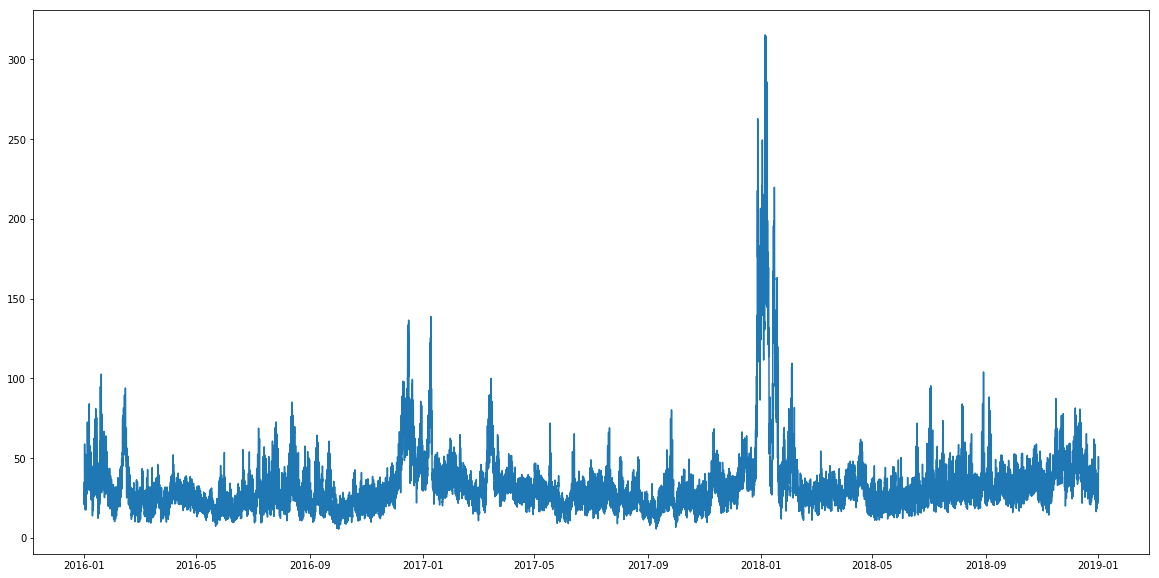

In [5]:
# Take a look at the first year of data for the first column.
plt.figure(figsize=(20,10))
plt.plot(df['forecast_lbmp__capitl'])
plt.show()

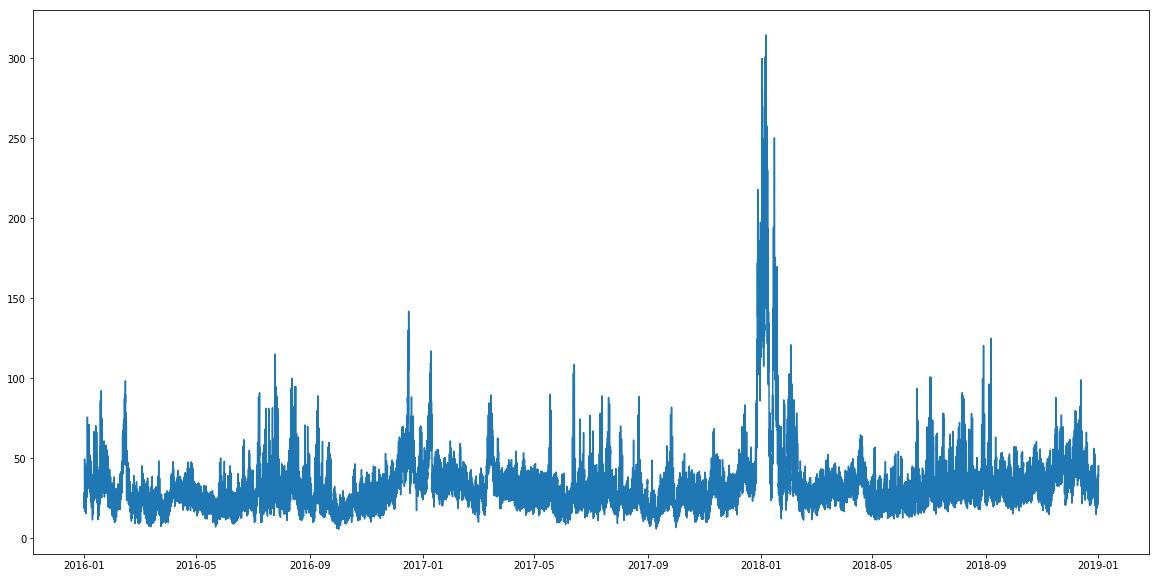

In [6]:
plt.figure(figsize=(20,10))
plt.plot(df['forecast_lbmp__nyc'])
plt.show()

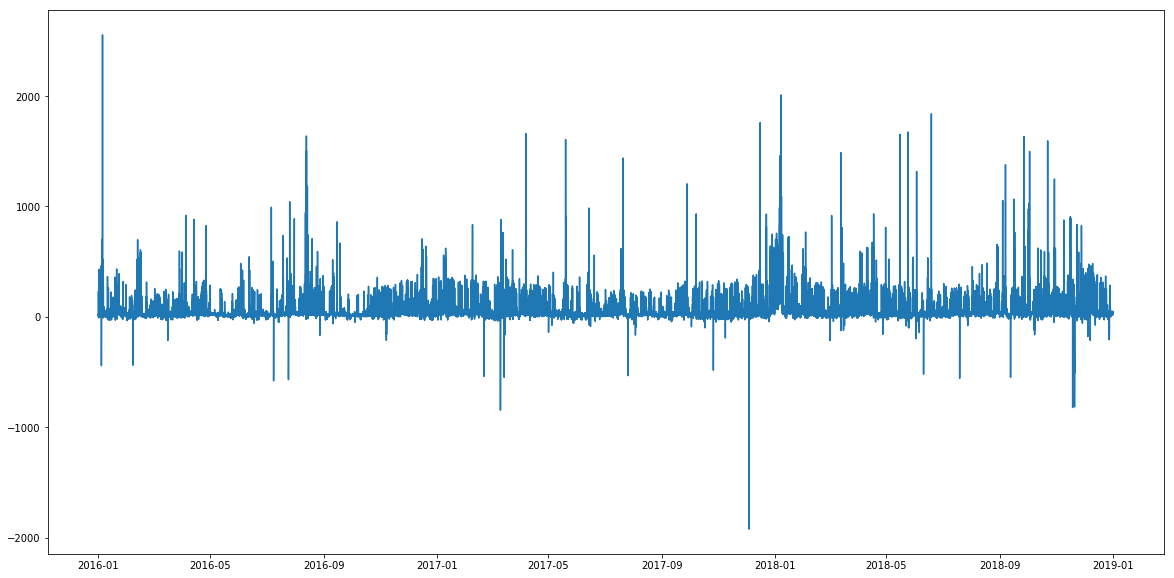

In [7]:
plt.figure(figsize=(20,10))
plt.plot(df['realtime_lbmp__nyc'])
plt.show()


# Shift realtime data ahead by one day

In [8]:
# We'll predict the lbmp in NYC.
pred_col = 'realtime_lbmp__nyc'

# First, extract the column we'll be making predictions on.
y = df[pred_col].copy(deep=True)

# Loop over the columns.
for c in df.columns:
    # In combine_all_data.py, all realtime data was prefixed with 'realtime_'.
    # When we encounter a realtime column, shift it by 12 spots (1 hour for
    # 5 minute intervals.)
    if c.startswith('realtime_'):
        df[c] = df[c].shift(12 * 24)

# After shifting the realtime data ahead, we have NaNs in our first
# 12 rows. Drop them.
df.dropna(inplace=True)

# Drop the same rows in y.
y = y[df.index]

print(y.head())
print(df[pred_col].head())

print('Realtime data shifted.')

# print(df.head())

Time Stamp
2016-01-02 00:00:00-05:00    43.75
2016-01-02 00:05:00-05:00    24.98
2016-01-02 00:10:00-05:00    26.01
2016-01-02 00:15:00-05:00     1.19
2016-01-02 00:20:00-05:00     1.20
Name: realtime_lbmp__nyc, dtype: float64
Time Stamp
2016-01-02 00:00:00-05:00     18.82
2016-01-02 00:05:00-05:00     18.82
2016-01-02 00:10:00-05:00    230.87
2016-01-02 00:15:00-05:00     54.19
2016-01-02 00:20:00-05:00     38.38
Name: realtime_lbmp__nyc, dtype: float64
Realtime data shifted.


# Split Data Into Testing vs. Training, Extract Feature We'll be Predicting

In [9]:
# Let's look at realtime LBMP in NYC.
# No need to drop features since we extracted 'y' before shifting all the realtime data.
x = df

# TODO: We probably shouldn't be using real-time data in training/predicting,
# right? This should maybe be a two-step process: Predict 5-minute real-time 
# (will need another network/model to do that), then plug that in for LMP
# training/predicting.
y_train = y['2016':'2017']
y_test = y['2018']
x_train = x['2016':'2017']
x_test = x['2018']

print('Data split for train vs. test.')

Data split for train vs. test.


# Scale Data in Various Ways

In [10]:
# We'll use "standard" scaling
# Scale y data.
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
# 
scaler_x = StandardScaler()
x_train_scaled = scaler_x.fit_transform(x_train.values)
x_test_scaled = scaler_x.transform(x_test.values)

# Write to file.
joblib.dump(scaler_y, 'standard_scaler_y.save')
joblib.dump(scaler_x, 'standard_scaler_x.save')

# Ensure we have no NaNs.
# np.isnan(x_train_scaled).any()

# Also do min/max scaling
scaler_mmy = MinMaxScaler()
y_train_scaled_mm = scaler_mmy.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled_mm = scaler_mmy.transform(y_test.values.reshape(-1, 1))
scaler_mmx = MinMaxScaler()
x_train_scaled_mm = scaler_mmx.fit_transform(x_train.values)
x_test_scaled_mm = scaler_mmx.transform(x_test.values)

# Write to file.
joblib.dump(scaler_mmy, 'min_max_scaler_y.save')
joblib.dump(scaler_mmx, 'min_max_scaler_x.save')

# Create a variant where we do both - first standard scaling then min/max scaling.
scaler_both_y = MinMaxScaler()
y_train_scaled_both = scaler_both_y.fit_transform(y_train_scaled.reshape(-1, 1))
y_test_scaled_both = scaler_both_y.transform(y_test_scaled.reshape(-1, 1))
scaler_both_x = MinMaxScaler()
x_train_scaled_both = scaler_both_x.fit_transform(x_train_scaled)
x_test_scaled_both = scaler_both_x.transform(x_test_scaled)

# Write to file.
joblib.dump(scaler_both_y, 'both_scaler_y.save')
joblib.dump(scaler_both_x, 'both_scaler_x.save')

print('Data has been scaled.')

Data has been scaled.


# Use Lasso to determine important features

In [11]:
lasso = LassoCV(cv=5, max_iter=100000, n_jobs=-1, fit_intercept=False)
lasso.fit(x_train_scaled, y_train_scaled.ravel())
print('Alpha: {}'.format(lasso.alpha_))
# print('Coefficients:')
# print(lin_reg.coef_)
non_zero = lasso.coef_ != 0.0
print('Number of non-zero coefficients: {}'.format((non_zero).sum()))
print('Features:')
features_lasso = df.columns.values[non_zero]
print(features_lasso)

Alpha: 0.008600873558096482
Number of non-zero coefficients: 18
Features:
['forecast_lbmp__dunwod' 'forecast_lbmp__longil' 'forecast_lbmp__nyc'
 'forecast_marginal_cost_congestion__genese'
 'forecast_marginal_cost_congestion__longil'
 'forecast_marginal_cost_congestion__west'
 'forecast_marginal_cost_losses__capitl'
 'forecast_marginal_cost_losses__genese'
 'forecast_marginal_cost_losses__pjm' 'realtime_lbmp__nyc'
 'realtime_lbmp__npx' 'realtime_marginal_cost_losses__genese'
 'realtime_load_north' 'relativehumidity_a' 'windspeed_a' 'windspeed_d'
 'windspeed_i' 'relativehumidity_j']


Coefficients:
[ 0.16380976 -0.03657606  0.13513653  0.0247739  -0.11310889  0.01316262
  0.04860829 -0.01892013  0.03997255  0.03584037  0.05387752  0.06628275
  0.01099392  0.03073334 -0.01433292  0.00874592 -0.03376295  0.01250277]


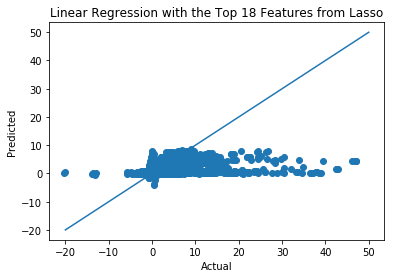

In [12]:
# Perform a simple linear regression with the non-zero lasso coefficients.
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(x_train_scaled[:, non_zero], y_train_scaled.ravel())
print('Coefficients:')
print(lin_reg.coef_)
y_pred = lin_reg.predict(x_test_scaled[:, non_zero])

plt.scatter(y_test_scaled, y_pred)
# If our predictions were perfect, they'd fall exactly on this line.
plt.plot([-20, 50], [-20,50])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression with the Top {} Features from Lasso'.format(len(lin_reg.coef_)))
plt.show()

# Use Random Forest to determine important features

In [13]:
# Create RandomForest classifier
# Original results came from n_estimators=1000, max_depth=7.
# Rolling that back to n_estimators=500, max_depth=5
# NOTE: It looks like our top ten features come out to be the same-ish.
rf = RandomForestRegressor(n_estimators=500, random_state=0, n_jobs=-1, max_depth=5)
rf.fit(x_train_scaled, np.ravel(y_train_scaled))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [14]:
# Display the top features.
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
# print feature importances in descending order
for f in range(15):
    print("{}. feature {} ({})".format(f + 1, df.columns[indices[f]],
                                       importances[indices[f]]))
    
# Grab as many features as we got from Lasso.
features_rf = df.columns.values[indices[0:len(features_lasso)]]

1. feature forecast_lbmp__nyc (0.20066392213260514)
2. feature windspeed_a (0.13610047124896207)
3. feature forecast_lbmp__hudvl (0.09188400660614487)
4. feature forecast_load_hudvl (0.0597635848355015)
5. feature forecast_marginal_cost_congestion__genese (0.055639335861332635)
6. feature forecast_marginal_cost_congestion__west (0.04627519800140813)
7. feature forecast_lbmp__dunwod (0.03210627335898806)
8. feature forecast_lbmp__genese (0.027283061054975126)
9. feature forecast_load_nyiso (0.021376365885350943)
10. feature windspeed_g (0.020367318613665076)
11. feature forecast_marginal_cost_losses__north (0.018259189377564208)
12. feature drybulbtemperature_j (0.017639918447695902)
13. feature forecast_lbmp__millwd (0.01404436488542578)
14. feature forecast_load_mhkvl (0.012574326827160991)
15. feature realtime_load_nyc (0.011277674809349405)


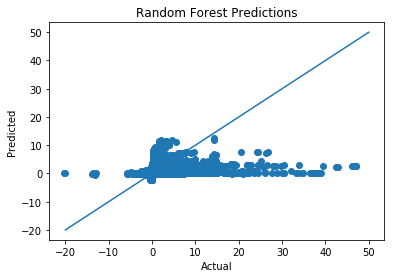

In [15]:
y_pred = rf.predict(x_test_scaled)

plt.scatter(y_test_scaled, y_pred)
# If our predictions were perfect, they'd fall exactly on this line.
plt.plot([-20, 50], [-20,50])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions')
plt.show()

# Compare Lasso and RandomForest features

In [16]:
common_features = set(features_lasso) & set(features_rf)
print('{} common features from Lasso and RandomForest:'.format(len(common_features)))
print(common_features)

# Let's grab the top 10 RF features and the top 10 Lasso features and create the intersection.
# Start by creating a dictionary of Lasso features.
lasso_dict = {}
for ind, col in enumerate(features_lasso):
    lasso_dict[col] = abs(lin_reg.coef_[ind])
    
# Sort.
lasso_top_ten = sorted(lasso_dict.items(), key=lambda kv: kv[1], reverse=True)
lasso_top_ten = [x[0] for x in lasso_top_ten[0:10]]

print('')
print('Top ten features for Lasso and RandomForest:')
top_ten_df = pd.DataFrame({'Lasso': lasso_top_ten, 'RandomForest': features_rf[0:10]})
print(top_ten_df)

# Take the union of the top ten features for both models.
features_to_use = list(set(lasso_top_ten) | set(features_rf[0:10]))
# print('')
# print('Union of top ten Lasso and top ten RF features ({} features):'.format(len(features_to_use)))
# print(features_to_use)

# Get the indices of these features in the original DataFrame.
col_list = list(df.columns.values)
feature_indices = [col_list.index(x) for x in features_to_use]

# Check.
print('Expected features:')
print(features_to_use)
print('Feautures reference by index:')
print(list(df.columns.values[feature_indices]))

5 common features from Lasso and RandomForest:
{'forecast_lbmp__nyc', 'forecast_marginal_cost_congestion__genese', 'windspeed_a', 'forecast_marginal_cost_congestion__west', 'forecast_lbmp__dunwod'}

Top ten features for Lasso and RandomForest:
                                       Lasso  \
0                      forecast_lbmp__dunwod   
1                         forecast_lbmp__nyc   
2  forecast_marginal_cost_congestion__longil   
3      realtime_marginal_cost_losses__genese   
4                         realtime_lbmp__npx   
5      forecast_marginal_cost_losses__capitl   
6         forecast_marginal_cost_losses__pjm   
7                      forecast_lbmp__longil   
8                         realtime_lbmp__nyc   
9                                windspeed_i   

                                RandomForest  
0                         forecast_lbmp__nyc  
1                                windspeed_a  
2                       forecast_lbmp__hudvl  
3                        forecast_load_

# Extract most important features

In [17]:
# Save data to file so we can use other notebooks to do the ML.
# Standard scaling:
pd.DataFrame(data=x_train_scaled[:, feature_indices],
             columns=df.columns[feature_indices]).to_csv('x_train.csv')
pd.DataFrame(data=x_test_scaled[:, feature_indices],
             columns=df.columns[feature_indices]).to_csv('x_test.csv')

pd.Series(data=y_train_scaled.ravel(), name=pred_col).to_csv('y_train.csv')
pd.Series(data=y_test_scaled.ravel(), name=pred_col).to_csv('y_test.csv')

# Min/max scaling:
pd.DataFrame(data=x_train_scaled_mm[:, feature_indices],
             columns=df.columns[feature_indices]).to_csv('x_train_mm.csv')
pd.DataFrame(data=x_test_scaled_mm[:, feature_indices],
             columns=df.columns[feature_indices]).to_csv('x_test_mm.csv')

pd.Series(data=y_train_scaled_mm.ravel(), name=pred_col).to_csv('y_train_mm.csv')
pd.Series(data=y_test_scaled_mm.ravel(), name=pred_col).to_csv('y_test_mm.csv')

# Both:
pd.DataFrame(data=x_train_scaled_both[:, feature_indices],
             columns=df.columns[feature_indices]).to_csv('x_train_both.csv')
pd.DataFrame(data=x_test_scaled_both[:, feature_indices],
             columns=df.columns[feature_indices]).to_csv('x_test_both.csv')

pd.Series(data=y_train_scaled_both.ravel(), name=pred_col).to_csv('y_train_both.csv')
pd.Series(data=y_test_scaled_both.ravel(), name=pred_col).to_csv('y_test_both.csv')

print('Scaled data saved to file.')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: FutureWarning: The signature of `Series.to_csv` was a

Scaled data saved to file.
